In [1]:
import torch
from omegaconf import OmegaConf
import hydra
import random
import numpy as np
import PIL.Image as PImage, PIL.ImageDraw as PImageDraw
import torchvision

In [2]:

device = "cuda:6"
ckpt_path = "logs/train/runs/var-cifar10/2024-12-23_20-44-11/checkpoints/last.ckpt"
ckpt = torch.load(ckpt_path,map_location="cpu")
ckpt['state_dict'].keys()
model_config_path = "configs/model/var.yaml"


model_config = OmegaConf.load(model_config_path)
model = hydra.utils.instantiate(model_config)
model.load_state_dict(ckpt["state_dict"])
model.eval()
model = model.to(device)
var = model.var
vae = model.vae_local

/tmp/ipykernel_2568957/853300986.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path,map_location="cpu")
/home/zouxuechao/miniconda3/envs/aigc/li


[constructor]  ==== flash_if_available=True (0/16), fused_if_available=True (fusing_add_ln=0/16, fusing_mlp=0/16) ==== 
    [VAR config ] embed_dim=256, num_heads=16, depth=16, mlp_ratio=4.0
    [drop ratios ] drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0666667 (tensor([0.0000, 0.0044, 0.0089, 0.0133, 0.0178, 0.0222, 0.0267, 0.0311, 0.0356,
        0.0400, 0.0444, 0.0489, 0.0533, 0.0578, 0.0622, 0.0667]))

[init_weights] VAR with init_std=0.0360844


/data/zouxuechao/aigc/src/models/var_module.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.var.vae_proxy[0].load_state_dict(torch.load(vae_config_path),strict=Tru

torch.Size([10, 32, 2, 2])
torch.Size([10, 32, 3, 3])
torch.Size([10, 32, 4, 4])
torch.Size([10, 32, 5, 5])
torch.Size([10, 32, 6, 6])
torch.Size([10, 32, 8, 8])
torch.Size([10, 32, 10, 10])
torch.Size([10, 32, 13, 13])
torch.Size([10, 32, 16, 16])
torch.Size([10, 32, 16, 16])


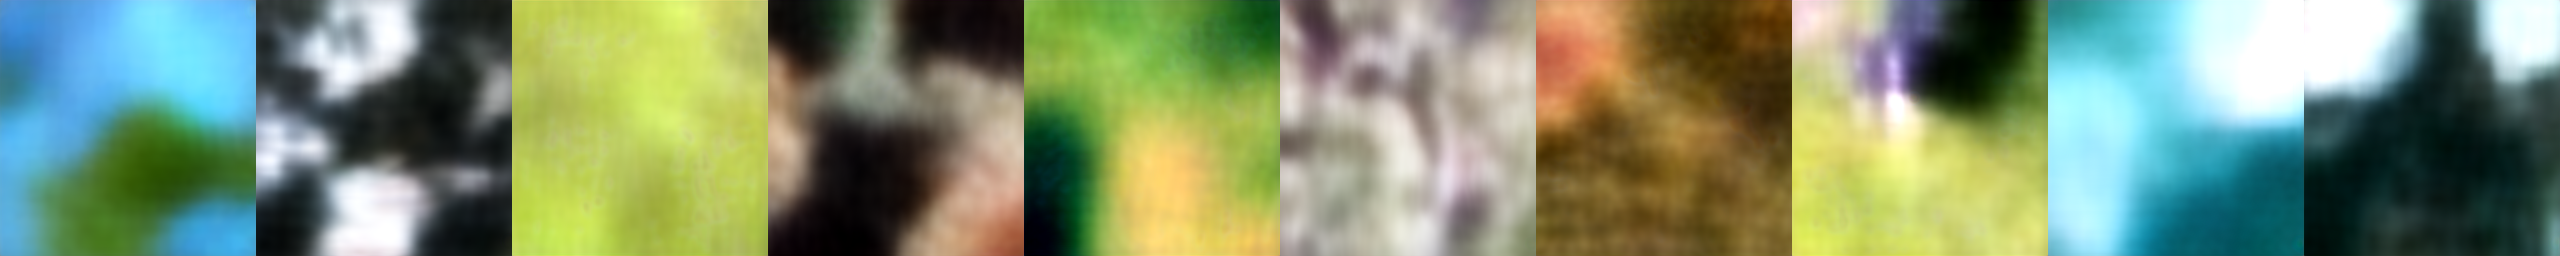

In [3]:
############################# 2. Sample with classifier-free guidance

# set args
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 250 #@param {type:"slider", min:0, max:1000, step:1}
cfg = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = (0,1,2,3,4,5,6,7,8,9)  #@param {type:"raw"}
more_smooth = False # True for more smooth output

# seed
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# run faster
tf32 = True
torch.backends.cudnn.allow_tf32 = bool(tf32)
torch.backends.cuda.matmul.allow_tf32 = bool(tf32)
torch.set_float32_matmul_precision('high' if tf32 else 'highest')

# sample
B = len(class_labels)
label_B: torch.LongTensor = torch.tensor(class_labels, device=device)
with torch.inference_mode():
    with torch.autocast('cuda', enabled=True, dtype=torch.float16, cache_enabled=True):    # using bfloat16 can be faster
        recon_B3HW = var.autoregressive_infer_cfg(B=B, label_B=label_B, cfg=cfg, top_k=900, top_p=0.95, g_seed=seed, more_smooth=more_smooth)

chw = torchvision.utils.make_grid(recon_B3HW, nrow=10, padding=0, pad_value=1.0)
chw = chw.permute(1, 2, 0).mul_(255).cpu().numpy()
chw = PImage.fromarray(chw.astype(np.uint8))
chw.show()